# Meter reading

I used Sean's code as a starting point and wrote a preparser to simplify the data input code.  Currently this discards the header information, but this could be changed.

There appears to be an offset problem between our kWh computation and the export field from the meter.

# Questions

- What does the average daily power timeseries (load profile) look like?
- Is the daily energy use changing over time?
- Is the peak power demanded changing over time?

In [1]:
import pandas as pd
import os as os
import xlrd
import datetime
import matplotlib as plt
import numpy as np
%matplotlib inline

# read in raw CSV file for preprocessing
atamali_file = open("../data-timeseries/Data_Logs Atamali Agustus.csv")

# dump lines from communications messages or empty lines and write to string
file_string = ''
omit_strings = ['Power Up', 'Communication Lost', 'Power Down', ',,,,,,,,,,,']
# there is information in the first 32 lines being dumped
for line in atamali_file.readlines()[32:]:
    if not any(omit in line for omit in omit_strings):
        file_string += line

# use pre-parsed string to read in data file to pandas and sort by date
import io
atamali = pd.read_csv(io.StringIO(file_string),
                      index_col=0, 
                      parse_dates=[0], 
                      thousands=',')
atamali = atamali.sort()

# create time differences
differences = np.diff(atamali.index.values)
# remove large time gaps from downtime
differences[differences>62e9]=0
# add extra value to beginning of array
#differences = np.concatenate((differences, differences[-1:]))
differences = np.concatenate((differences[:1], differences))
atamali['differences'] = differences
# cast in seconds rather than nanoseconds
atamali['differences'] = atamali['differences'].astype('timedelta64[s]')

/Users/dsoto/anaconda/envs/sotolab/lib/python3.4/site-packages/ipykernel/__main__.py:31: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.


In [2]:
# use current and voltage and (assumed) time step to calculate energy in each interval
atamali['kWh actual'] = (atamali['Avg Voltage L1/L12'] * atamali['Avg Current L1'] + 
                         atamali['Avg Voltage L2/L23'] * atamali['Avg Current L2'] + 
                         atamali['Avg Voltage L3/L31'] * atamali['Avg Current L3']) / 1000 / 3600 * atamali['differences']
atamali['acc kWh'] = atamali['kWh actual'].cumsum()
atamali['meter kWh'] = atamali['kWh export'] - atamali['kWh export'].iloc[0]

In [3]:
atamali.head()

,Unnamed: 1,kWh export,Avg Voltage L1/L12,Avg Voltage L2/L23,Avg Voltage L3/L31,Avg Current L1,Avg Current L2,Avg Current L3,kVA sliding window Demand,Maximum real-time Total kVA,Trigger,differences,kWh actual,acc kWh,meter kWh
Timestamp,,,,,,,,,,,,,,,
2015-08-01 00:00:00.027,NaN,1309,220.2,221.5,218.7,9.13,4.95,11.05,2.82,2.72,1,59,0.090524,0.090524,0
2015-08-01 00:01:00.019,NaN,1309,220.1,221.5,218.6,9.13,4.98,11.07,2.70,2.74,1,59,0.090671,0.181195,0
2015-08-01 00:02:00.001,NaN,1309,220.2,221.5,218.6,9.08,5.16,11.04,2.70,2.64,1,59,0.091052,0.272247,0
2015-08-01 00:03:00.014,NaN,1309,219.5,221.6,217.7,9.08,6.27,11.25,2.70,2.47,1,60,0.097194,0.369440,0
2015-08-01 00:04:00.023,NaN,1309,220.1,221.5,218.6,9.08,4.99,11.21,2.70,2.80,1,60,0.092572,0.462012,0


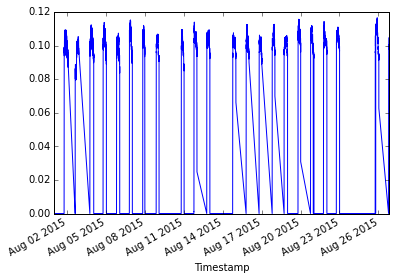

In [4]:
atamali['kWh actual'].plot()

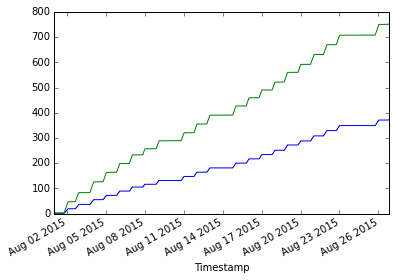

In [5]:
# the attempts above have not yet reconciled the difference
atamali['meter kWh'].plot()
atamali['acc kWh'].plot()